In [18]:
#utility
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

#visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import pyecharts

#pre-processing
import missingno as msno
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline


# Data import

In [19]:
data = pd.read_csv('data.csv')
#data.tail(20)

# Feature engineering

<AxesSubplot:>

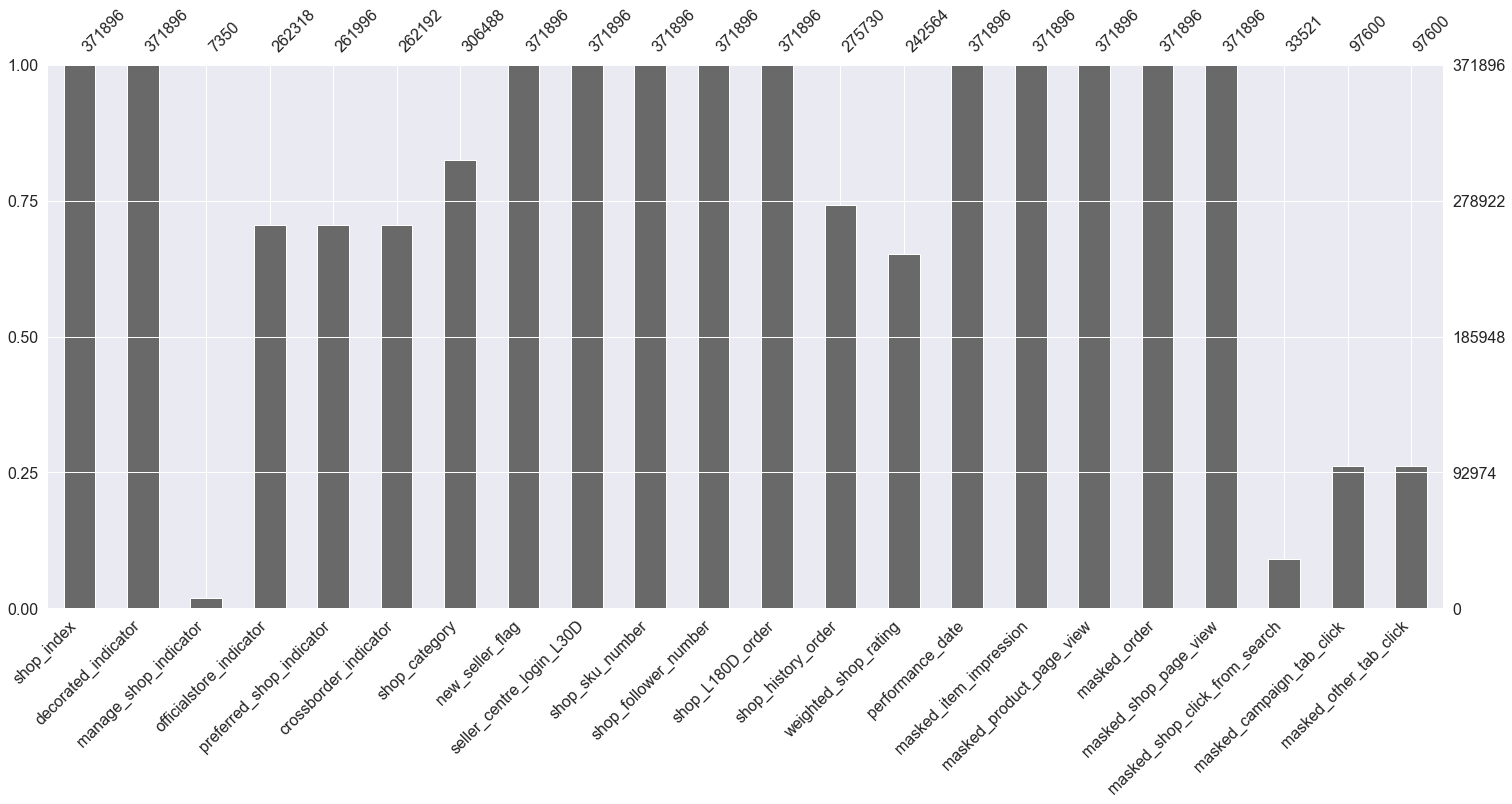

In [20]:
msno.bar(data)

In [21]:
#simple fill-null
data["manage_shop_indicator"].fillna(0,inplace=True)
data["shop_category"].fillna(np.random.randint(0,19), inplace =True)

#convert text into numeric value
data['decorated_indicator'] = np.where(data['decorated_indicator']== 'N', 0, 1)
data['new_seller_flag'] = np.where(data['new_seller_flag']== 'old_seller', 0, 1)
data['shop_category'] = np.where(data['shop_category']== 'Home & Living', int(0), 
                                 np.where(data['shop_category']== 'Hobbies & Stationery', int(1), 
                                np.where(data['shop_category']== 'Men\'s Bags & Accessories', int(2),
                                np.where(data['shop_category']== 'Toys, Games & Collectibles', int(3), 
                                np.where(data['shop_category']== 'Motors', int(4),
                                np.where(data['shop_category']== 'Makeup & Fragrances', int(5), 
                                np.where(data['shop_category']== 'Health & Personal Care', int(6), 
                                np.where(data['shop_category']== 'Men\'s Apparel', int(7), 
                                np.where(data['shop_category']== 'Women\'s Apparel', int(8), 
                                np.where(data['shop_category']== 'Babies & Kids', int(9), 
                                np.where(data['shop_category']== 'Home Appliances', int(10), 
                                np.where(data['shop_category']== 'Pet Care', int(11),
                                np.where(data['shop_category']== 'Home Entertainment', int(12), 
                                np.where(data['shop_category']== 'Mobile Accessories', int(13), 
                                np.where(data['shop_category']== 'Women\'s Bags', int(14), 
                                np.where(data['shop_category']== 'Sports & Travel', int(15), 
                                np.where(data['shop_category']== 'Women Shoes', int(16), 
                                np.where(data['shop_category']== 'Mobiles & Gadgets', int(17), 
                                np.where(data['shop_category']== 'Cameras', int(18), 
                                np.where(data['shop_category']== 'Gaming', int(19), 
                                int(20)))))))))))))))))))))

<AxesSubplot:>

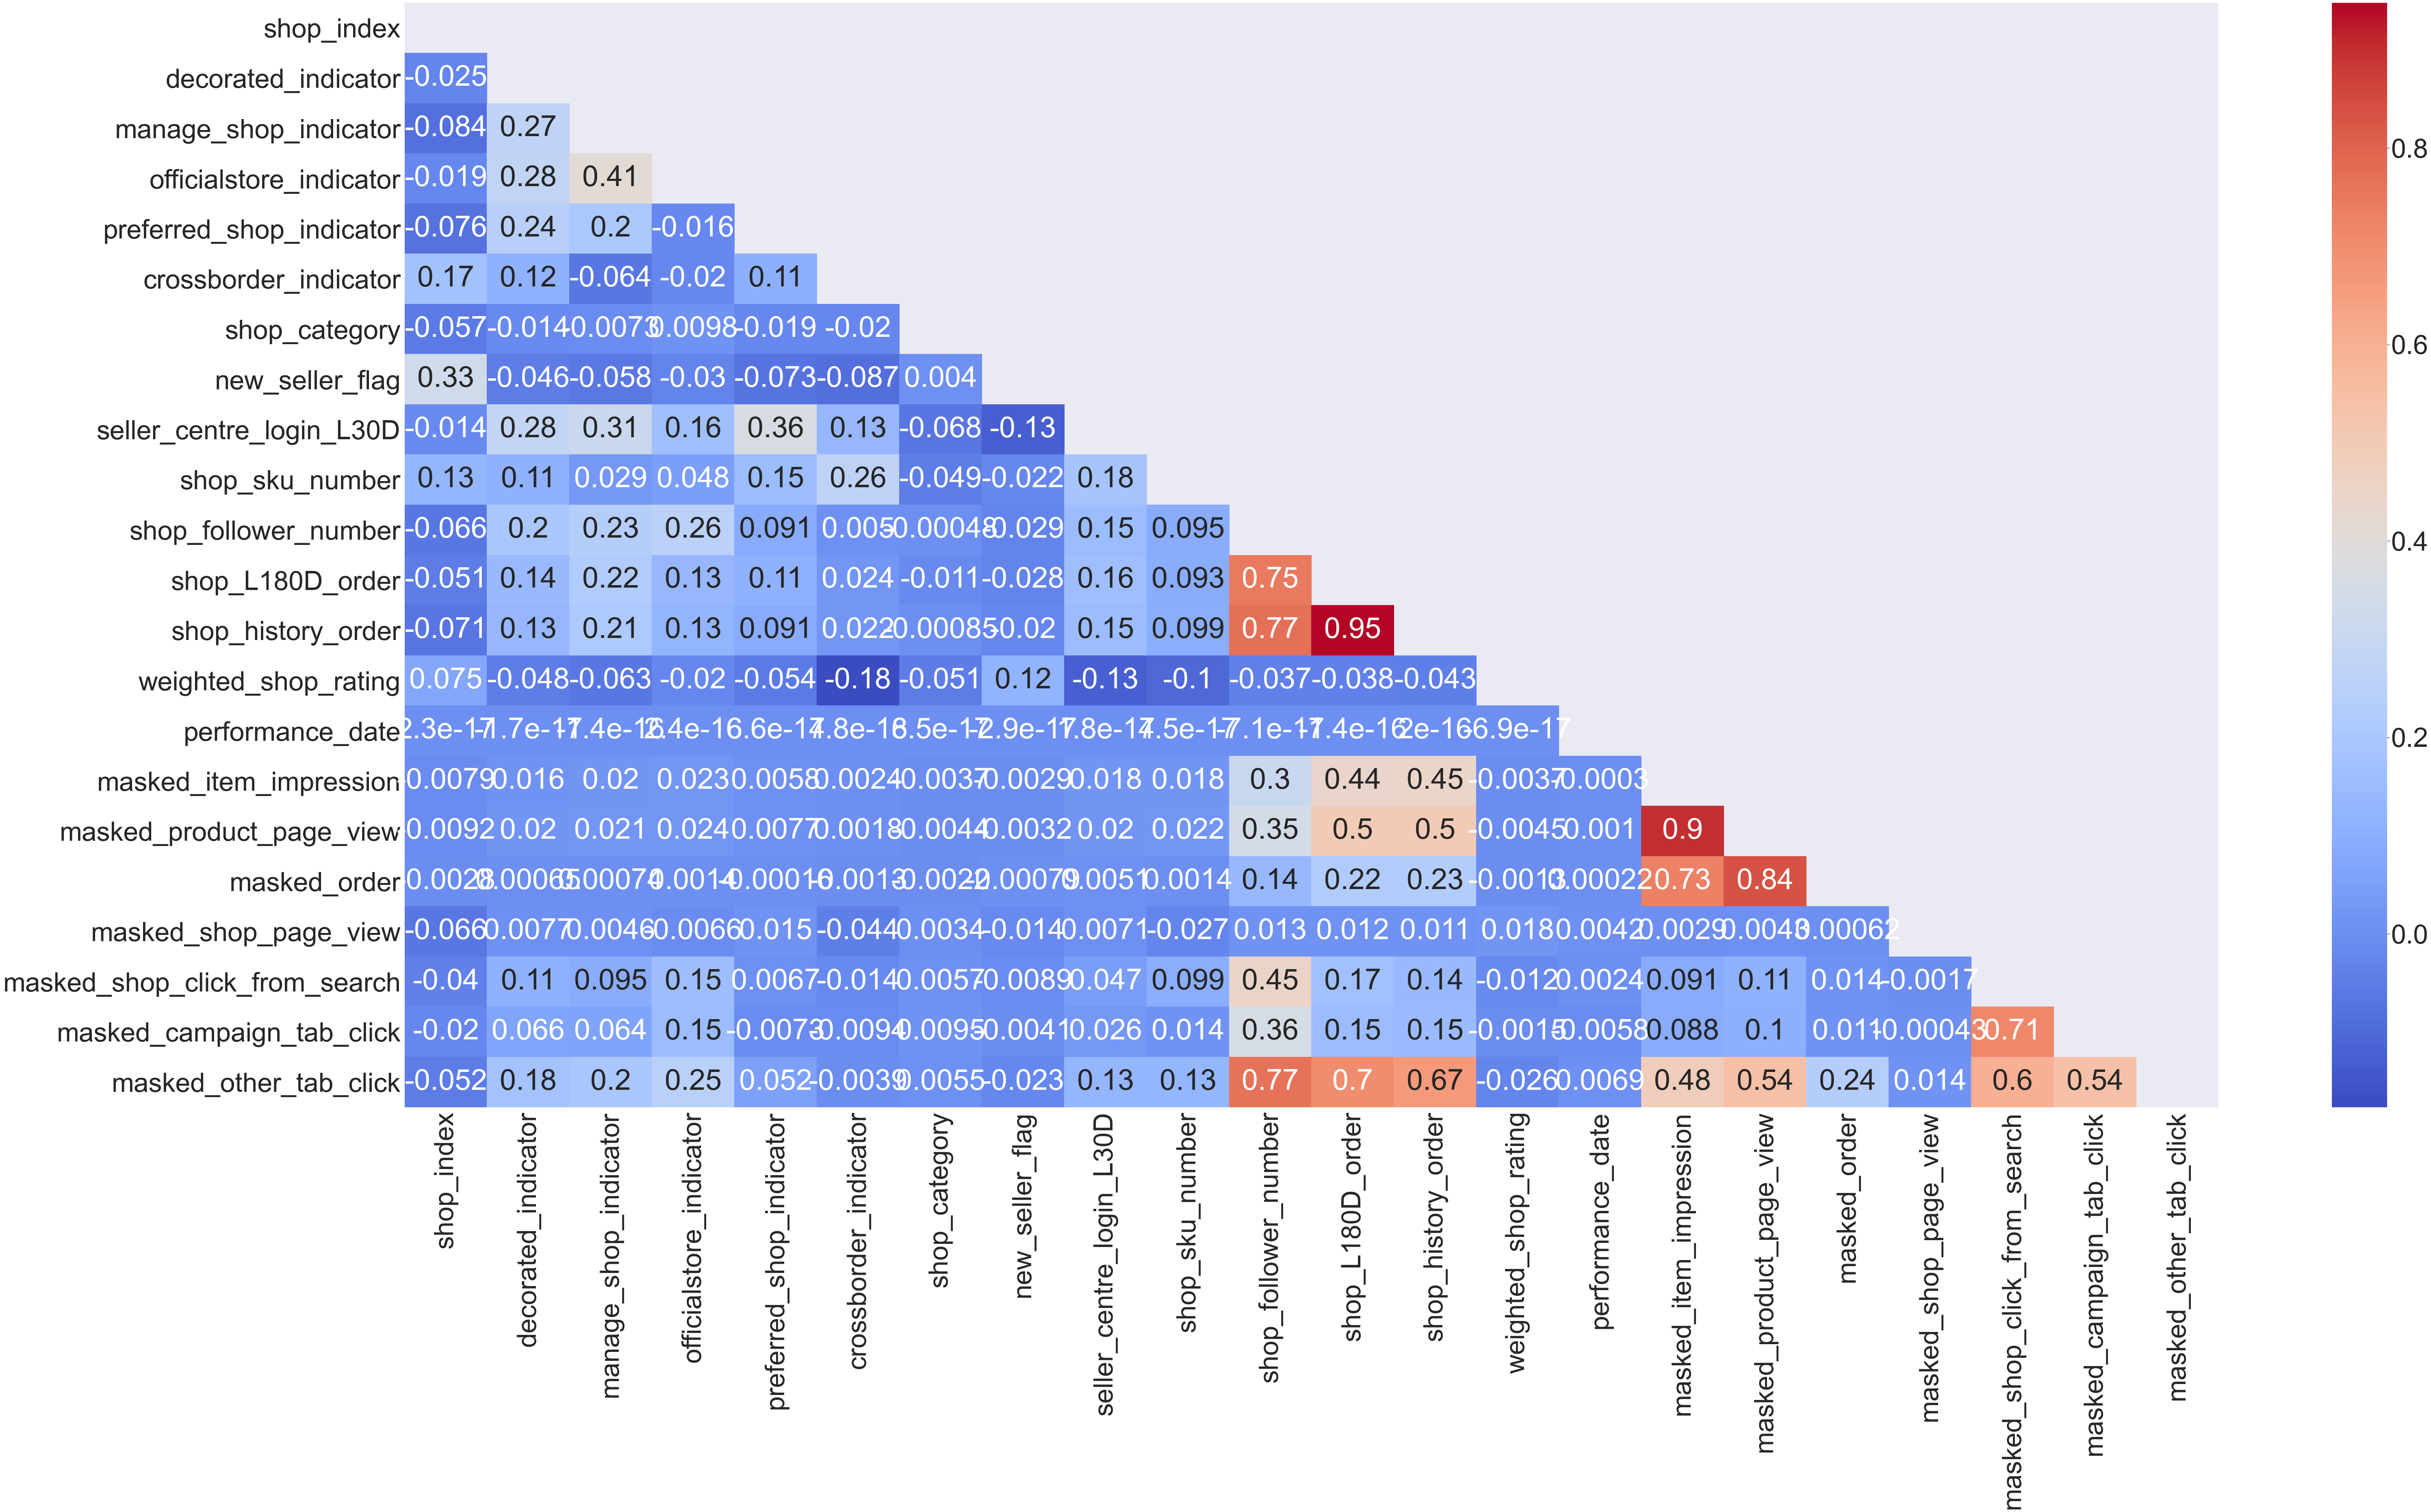

In [22]:
#Correlation Matrix
sns.set(font_scale=6)
plt.figure(figsize=(100,50))
corr = data.corr()
matrix = np.triu(corr)
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=matrix)
#corr

In [23]:
#drop columns with high correlation
data = data.drop(columns=['shop_history_order', 'masked_product_page_view'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371896 entries, 0 to 371895
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   shop_index                     371896 non-null  int64  
 1   decorated_indicator            371896 non-null  int32  
 2   manage_shop_indicator          371896 non-null  float64
 3   officialstore_indicator        262318 non-null  float64
 4   preferred_shop_indicator       261996 non-null  float64
 5   crossborder_indicator          262192 non-null  float64
 6   shop_category                  371896 non-null  int32  
 7   new_seller_flag                371896 non-null  int32  
 8   seller_centre_login_L30D       371896 non-null  int64  
 9   shop_sku_number                371896 non-null  int64  
 10  shop_follower_number           371896 non-null  int64  
 11  shop_L180D_order               371896 non-null  int64  
 12  weighted_shop_rating          

# Dataset splitting

In [24]:
whitelist = data[data['decorated_indicator'] == 1]
non_whitelist = data[data['decorated_indicator'] == 0]

## whitelist data

<AxesSubplot:>

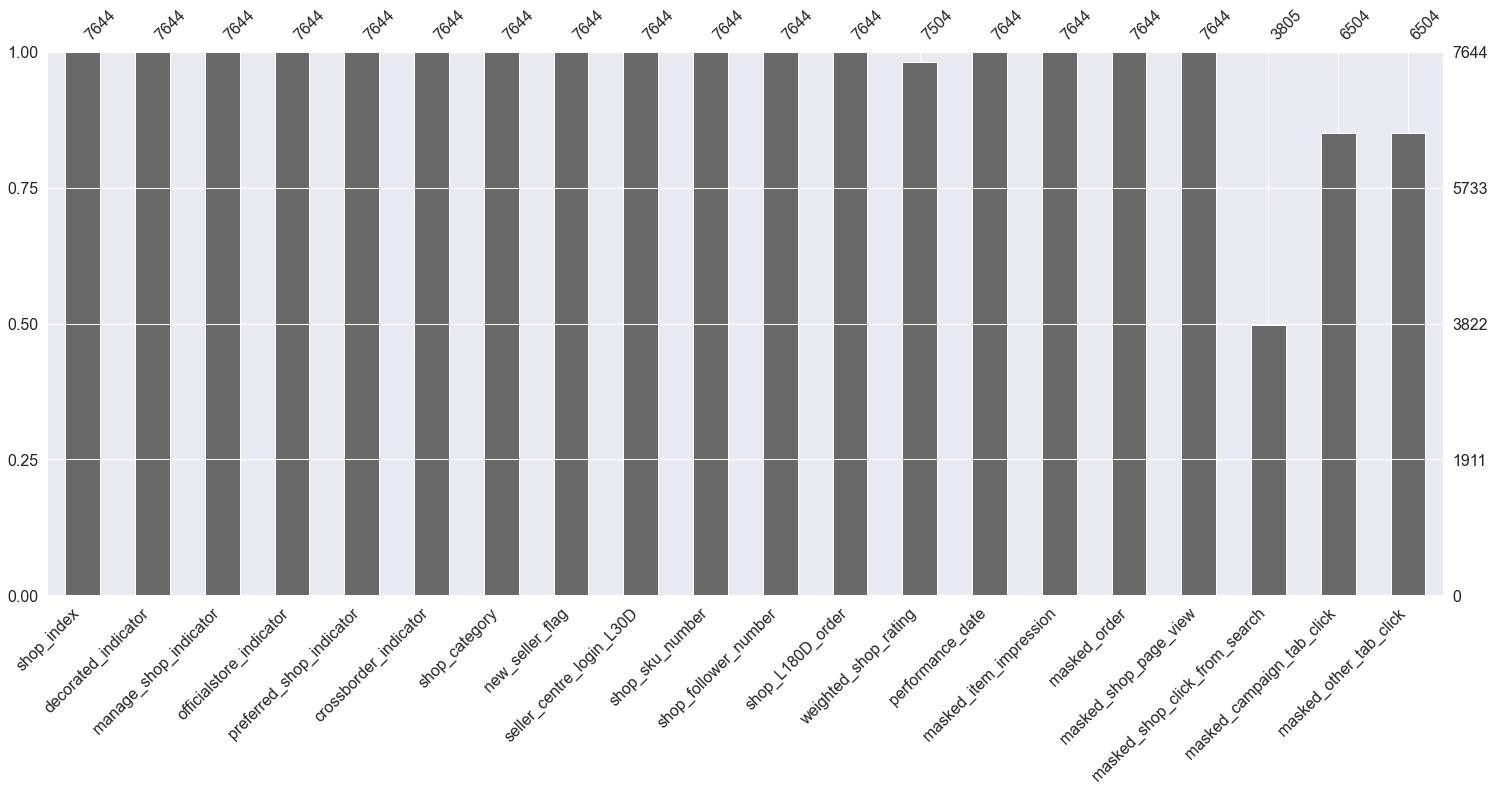

In [25]:
msno.bar(whitelist)

In [26]:
# for variables with few missing values, drop them (as the no. of missing values is vary small)
whitelist.dropna(subset=["weighted_shop_rating"],inplace=True)

<ipython-input-26-16d26b2430d2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whitelist.dropna(subset=["weighted_shop_rating"],inplace=True)


In [27]:
#K-NN null value fill-up
imputer = KNNImputer(n_neighbors=19, weights='uniform', metric='nan_euclidean')
imputer.fit(whitelist.iloc[:,1:])
whitelist_filled = imputer.transform(whitelist.iloc[:,1:])

#label the filled values with column name and add shop_id back
whitelist_filled=pd.DataFrame(whitelist_filled,columns=list(whitelist.columns)[1:])
whitelist_filled['shop_index']=whitelist['shop_index'].values

#export filled whitelist data
whitelist_filled.to_csv('whitelist_filled.csv')

# non-whitelist data

<AxesSubplot:>

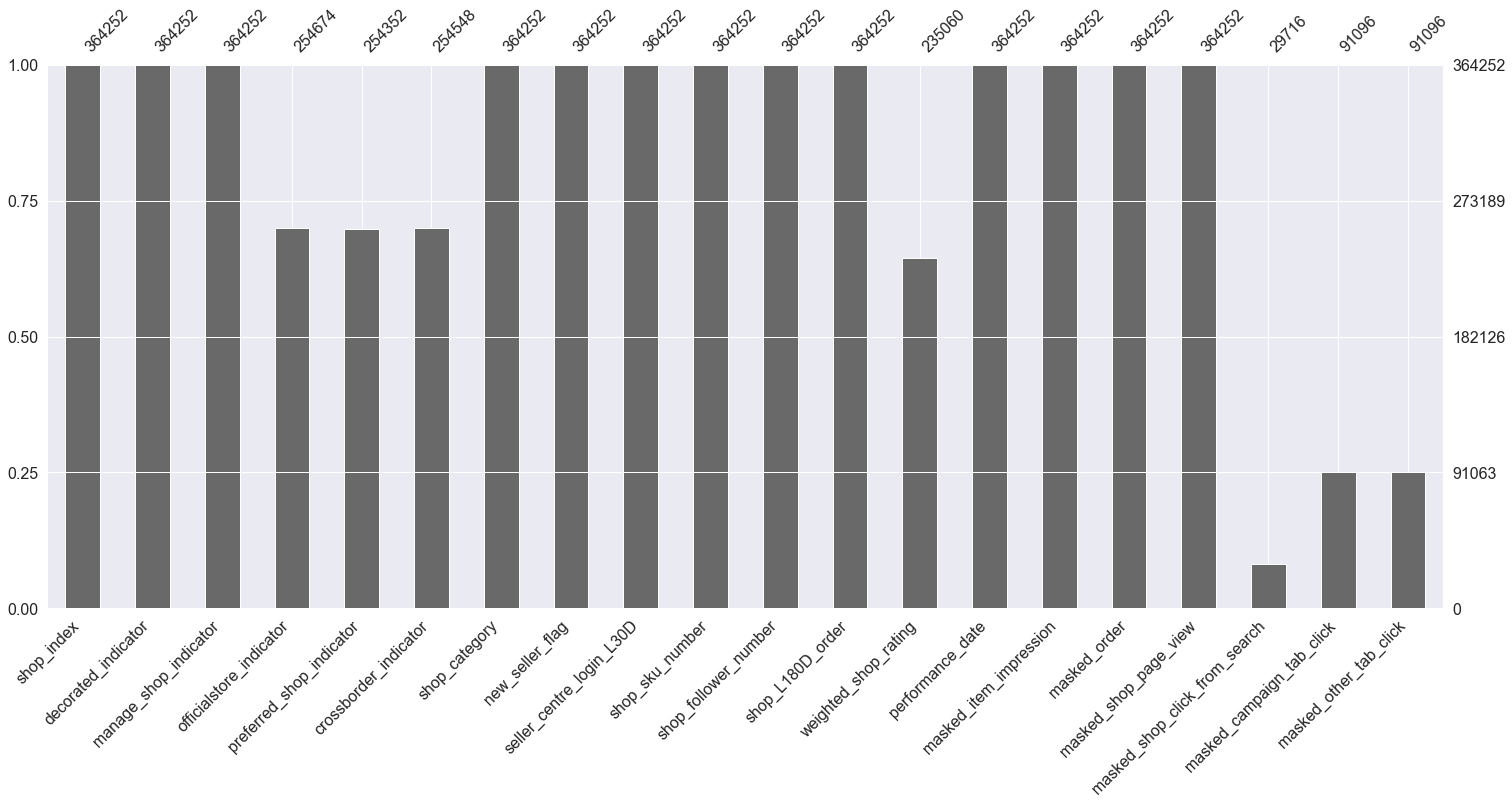

In [28]:
msno.bar(non_whitelist)

In [29]:
#fill for 3 indicator columns
non_whitelist_test=non_whitelist.copy(deep=False)
non_whitelist_test = non_whitelist_test.drop(columns=['masked_shop_click_from_search','masked_campaign_tab_click', 'masked_other_tab_click'])
non_whitelist_test_shop=non_whitelist_test.groupby('shop_index').mean() #construct a shop_id >> indicator pair

non_whitelist_test_shop["officialstore_indicator"].fillna(np.random.randint(0,1), inplace =True)
non_whitelist_test_shop["preferred_shop_indicator"].fillna(np.random.randint(0,1), inplace =True)
non_whitelist_test_shop["crossborder_indicator"].fillna(np.random.randint(0,1), inplace =True)

#fill NaN according to value assigned in non_whitelist_test_shop
for index, row in non_whitelist[non_whitelist['officialstore_indicator'].isnull()].iterrows():
    non_whitelist.loc[index,'officialstore_indicator']=non_whitelist_test_shop['officialstore_indicator'][row['shop_index']]

for index, row in non_whitelist[non_whitelist['preferred_shop_indicator'].isnull()].iterrows():
    non_whitelist.loc[index,'preferred_shop_indicator']=non_whitelist_test_shop['preferred_shop_indicator'][row['shop_index']]

for index, row in non_whitelist[non_whitelist['crossborder_indicator'].isnull()].iterrows():
    non_whitelist.loc[index,'crossborder_indicator']=non_whitelist_test_shop['crossborder_indicator'][row['shop_index']]


C:\Users\65843\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [31]:
#K-NN null value fill-up
imputer = KNNImputer(n_neighbors=19, weights='uniform', metric='nan_euclidean')
imputer.fit(non_whitelist.iloc[:,1:]) #exclude shop_id
non_whitelist_filled = imputer.transform(non_whitelist.iloc[:,1:]) #result is array format

#transform result array into df
non_whitelist_filled=pd.DataFrame(non_whitelist_filled,columns=list(non_whitelist.columns)[1:])
non_whitelist_filled['shop_index']=non_whitelist['shop_index'].values

#export into csv
non_whitelist_filled.to_csv('non_whitelist_filled.csv')

PermissionError: [Errno 13] Permission denied: 'non_whitelist_filled.csv'